# Importações e funções auxiliares

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agent import Agent, QLearningAgent, MonteCarloAgent
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """

    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

pygame 2.0.1 (SDL 2.0.14, Python 3.9.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import math
from scipy.spatial import distance

def reward_euclidean(env):
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = distance.euclidean(player_pos, food_pos)
    reward = 0
    if env.game.crash:
        reward = -10000
    elif env.player.eaten:
        reward = 10000
    else:
        if dist > 100:
            reward = (-1*dist)/10
        if dist <= 100:
            reward = (100-dist)/10

    return reward

# Monte Carlo

### Every Visit

me 194      Score: 4

Game 195      Score: 11

Game 196      Score: 9

Game 197      Score: 15

Game 198      Score: 12

Game 199      Score: 5

Game 200      Score: 13

Game 201      Score: 23

Game 202      Score: 12

Game 203      Score: 20

Game 204      Score: 19

Game 205      Score: 12

Game 206      Score: 6

Game 207      Score: 8

Game 208      Score: 23

Game 209      Score: 10

Game 210      Score: 28

Game 211      Score: 18

Game 212      Score: 25

Game 213      Score: 3

Game 214      Score: 18

Game 215      Score: 19

Game 216      Score: 5

Game 217      Score: 14

Game 218      Score: 16

Game 219      Score: 13

Game 220      Score: 11

Game 221      Score: 22

Game 222      Score: 9

Game 223      Score: 28

Game 224      Score: 5

Game 225      Score: 20

Game 226      Score: 10

Game 227      Score: 11

Game 228      Score: 19

Game 229      Score: 17

Game 230      Score: 15

Game 231      Score: 15

Game 232      Score: 23

Game 233      Score: 18

Game 234   

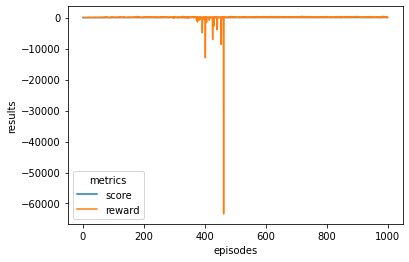

Run time: 166.49454498291016 seconds
Max. Score: 44
Mean Last Scores: 18.6


In [6]:
def run_monte_carlo(agent: Agent, reward_function, episodes, display, speed, verbose=True, first_visit=False):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = {} #defaultdict(float)
    returns_count = {} #defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            states_and_actions_visited.append((state2, action2, reward))

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        #sa_in_episode = set([(tuple(x[0]), x[1]) for x in states_and_actions_visited])
        G = 0
        for i, step in enumerate(states_and_actions_visited[::-1]):
            state, action, r = step
            G = agent.gamma*G + r

            do_update = True

            if first_visit:
                if state in [x[0] for x in states_and_actions_visited[::-1][len(states_and_actions_visited)-i:]]:
                    do_update = False

            if do_update:
                sa_pair = (step[0], decode_action(step[1]))

                if sa_pair in returns_sum:
                    returns_sum[sa_pair] += G
                else:
                    returns_sum[sa_pair] = G

                if sa_pair in returns_count:
                    returns_count[sa_pair] += 1.0
                else:
                    returns_count[sa_pair] = 1

                average = returns_sum[sa_pair] / returns_count[sa_pair]
                agent.Q[sa_pair[0], sa_pair[1] ] = average
                #agent.Q[state, action] = agent.Q[state, action] + 1/returns_count[sa_pair]

        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

        end = time.time()
        diff = end - start
        print()
        if diff > 600: # 10min
            break


    return metrics

N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### First Visit

 Score: 2

Game 176      Score: 5

Game 177      Score: 2

Game 178      Score: 10

Game 179      Score: 3

Game 180      Score: 3

Game 181      Score: 7

Game 182      Score: 6

Game 183      Score: 4

Game 184      Score: 5

Game 185      Score: 5

Game 186      Score: 4

Game 187      Score: 4

Game 188      Score: 13

Game 189      Score: 3

Game 190      Score: 6

Game 191      Score: 2

Game 192      Score: 1

Game 193      Score: 3

Game 194      Score: 9

Game 195      Score: 4

Game 196      Score: 6

Game 197      Score: 4

Game 198      Score: 3

Game 199      Score: 2

Game 200      Score: 2

Game 201      Score: 5

Game 202      Score: 3

Game 203      Score: 7

Game 204      Score: 11

Game 205      Score: 8

Game 206      Score: 6

Game 207      Score: 3

Game 208      Score: 2

Game 209      Score: 8

Game 210      Score: 5

Game 211      Score: 6

Game 212      Score: 4

Game 213      Score: 4

Game 214      Score: 7

Game 215      Score: 6

Game 216      Score: 2

Ga

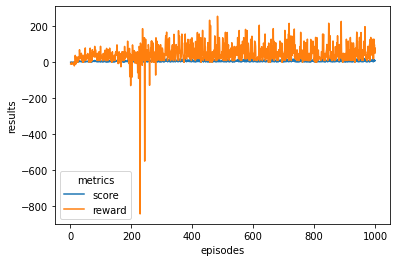

Run time: 99.64312219619751 seconds
Max. Score: 27
Mean Last Scores: 7.48


In [6]:
N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0

Game 2      Score: 0

Game 3      Score: 0

Game 4      Score: 1

Game 5      Score: 0

Game 6      Score: 0

Game 7      Score: 0

Game 8      Score: 0

Game 9      Score: 0

Game 10      Score: 1

Game 11      Score: 0

Game 12      Score: 1

Game 13      Score: 3

Game 14      Score: 2

Game 15      Score: 0

Game 16      Score: 1

Game 17      Score: 0

Game 18      Score: 0

Game 19      Score: 2

Game 20      Score: 0

Game 21      Score: 4

Game 22      Score: 3

Game 23      Score: 0

Game 24      Score: 0

Game 25      Score: 0

Game 26      Score: 0

Game 27      Score: 2

Game 28      Score: 3

Game 29      Score: 1

Game 30      Score: 2

Game 31      Score: 1

Game 32      Score: 1

Game 33      Score: 2

Game 34      Score: 2

Game 35      Score: 4

Game 36      Score: 3

Game 37      Score: 3

Game 38      Score: 2

Game 39      Score: 7

Game 40      Score: 1

Game 41      Score: 0

Game 42      Score: 8

Game 43      Score: 5

Game 44      Score: 

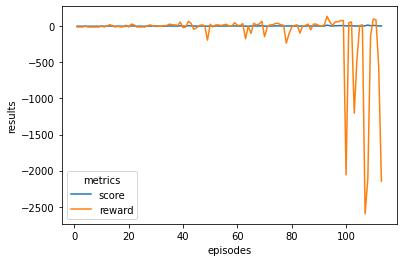

Run time: 1292.8808000087738 seconds
Max. Score: 16
Mean Last Scores: 4.68


In [7]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

re: 0

Game 168      Score: 0

Game 169      Score: 0

Game 170      Score: 0

Game 171      Score: 0

Game 172      Score: 0

Game 173      Score: 0

Game 174      Score: 0

Game 175      Score: 0

Game 176      Score: 0

Game 177      Score: 0

Game 178      Score: 0

Game 179      Score: 0

Game 180      Score: 0

Game 181      Score: 0

Game 182      Score: 0

Game 183      Score: 0

Game 184      Score: 0

Game 185      Score: 0

Game 186      Score: 0

Game 187      Score: 0

Game 188      Score: 0

Game 189      Score: 0

Game 190      Score: 0

Game 191      Score: 0

Game 192      Score: 0

Game 193      Score: 0

Game 194      Score: 0

Game 195      Score: 0

Game 196      Score: 0

Game 197      Score: 0

Game 198      Score: 0

Game 199      Score: 0

Game 200      Score: 0

Game 201      Score: 0

Game 202      Score: 0

Game 203      Score: 0

Game 204      Score: 0

Game 205      Score: 0

Game 206      Score: 0

Game 207      Score: 0

Game 208      Score: 0

Game 209 

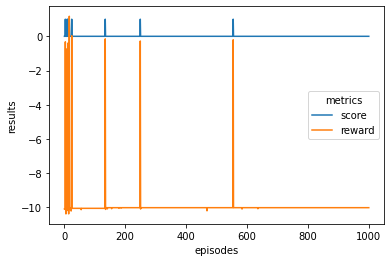

Run time: 2.699418306350708 seconds
Max. Score: 1
Mean Last Scores: 0.0


In [8]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

197      Score: 11

Game 198      Score: 10

Game 199      Score: 17

Game 200      Score: 12

Game 201      Score: 11

Game 202      Score: 16

Game 203      Score: 30

Game 204      Score: 25

Game 205      Score: 10

Game 206      Score: 23

Game 207      Score: 16

Game 208      Score: 11

Game 209      Score: 9

Game 210      Score: 9

Game 211      Score: 3

Game 212      Score: 13

Game 213      Score: 6

Game 214      Score: 25

Game 215      Score: 20

Game 216      Score: 16

Game 217      Score: 20

Game 218      Score: 15

Game 219      Score: 10

Game 220      Score: 6

Game 221      Score: 10

Game 222      Score: 24

Game 223      Score: 14

Game 224      Score: 13

Game 225      Score: 20

Game 226      Score: 6

Game 227      Score: 9

Game 228      Score: 13

Game 229      Score: 12

Game 230      Score: 8

Game 231      Score: 18

Game 232      Score: 4

Game 233      Score: 14

Game 234      Score: 3

Game 235      Score: 21

Game 236      Score: 11

Game 237      S

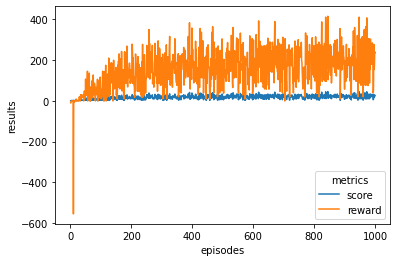

Run time: 32.44448137283325 seconds
Max. Score: 45
Mean Last Scores: 22.22


In [4]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

re: 2

Game 168      Score: 2

Game 169      Score: 3

Game 170      Score: 2

Game 171      Score: 4

Game 172      Score: 6

Game 173      Score: 3

Game 174      Score: 1

Game 175      Score: 1

Game 176      Score: 1

Game 177      Score: 3

Game 178      Score: 0

Game 179      Score: 1

Game 180      Score: 4

Game 181      Score: 2

Game 182      Score: 2

Game 183      Score: 1

Game 184      Score: 1

Game 185      Score: 1

Game 186      Score: 3

Game 187      Score: 3

Game 188      Score: 4

Game 189      Score: 2

Game 190      Score: 1

Game 191      Score: 3

Game 192      Score: 1

Game 193      Score: 2

Game 194      Score: 7

Game 195      Score: 3

Game 196      Score: 2

Game 197      Score: 1

Game 198      Score: 2

Game 199      Score: 2

Game 200      Score: 4

Game 201      Score: 1

Game 202      Score: 4

Game 203      Score: 3

Game 204      Score: 2

Game 205      Score: 1

Game 206      Score: 4

Game 207      Score: 3

Game 208      Score: 2

Game 209 

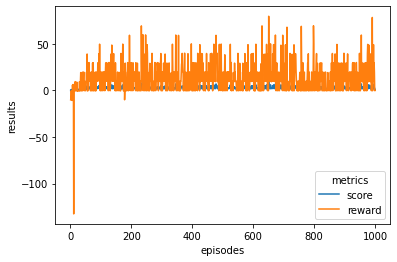

Run time: 5.89633846282959 seconds
Max. Score: 9
Mean Last Scores: 2.96


In [5]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))